In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
from tqdm import tqdm
from collections import defaultdict

import matplotlib.pyplot as plt

import sys; sys.path.append('../PGDL/sample_code_submission/')
from internal_rep.matrix_funcs import \
    get_KF_Schatten_norms, \
    compute_complexity, \
    get_df_tau, \
    evalues_from_regions, \
    get_local_rad_bound

In [2]:
def sample_dataset(x, y, n_samples, seed=None):
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed(int(time.time()))

    indices = np.random.choice(range(x.shape[0]), size=n_samples, replace=False)
    x = x[indices]
    y = y[indices]
    return x, y

def prepare_mnist_dataset(
    batch_size=64,
    train_sample_size=None,
    test_sample_size=None,
    seed=None,
    shuffle=True,
    shuffle_label_frac=None
):
    mnist = tf.keras.datasets.mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()#path='/mnt/ssd3/ronan/tensorflow_datasets/')
    y_train = y_train.astype('int32')
    y_test = y_test.astype('int32')

    if train_sample_size is not None:
        x_train, y_train = sample_dataset(x_train, y_train, int(train_sample_size), seed)
        if shuffle:
            shuffle_indices = np.arange(train_sample_size)
            np.random.seed(seed)
            np.random.shuffle(shuffle_indices)
            x_train = x_train[shuffle_indices]
            y_train = y_train[shuffle_indices]
        if shuffle_label_frac is not None:
            n_shuffle = int(shuffle_label_frac * train_sample_size)
            y_shuffle = y_train[:n_shuffle]
            np.random.seed(seed)
            np.random.shuffle(y_shuffle)
            y_train[:n_shuffle] = y_shuffle

    if test_sample_size is not None:
        x_test, y_test = sample_dataset(x_test, y_test, int(test_sample_size), seed)

    x_train, x_test = tf.cast(x_train, tf.float32) / 255.0, tf.cast(x_test, tf.float32) / 255.0
    print(f"x_train.shape={x_train.shape} y_train={y_train.shape} "
                 f"x_test.shape={x_test.shape} y_test={y_test.shape}")

    shuffle_buffer = 1000
    prefetch_buffer = 1000
    dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    # dataset = dataset.shuffle(shuffle_buffer)
    dataset_train = dataset_train.prefetch(prefetch_buffer).batch(batch_size)
    dataset_test = dataset_test.prefetch(prefetch_buffer).batch(batch_size)
    
    return dataset_train, dataset_test # , (x_train, y_train), (x_test, y_test)

## Models

In [3]:
# Source https://github.com/lilianweng/generalization-experiment/blob/master/utils.py
def dense_nn(inputs, layers_sizes, name="fc", reuse=False, output_fn=None,
             dropout_keep_prob=None, training=True):
    logging.info(f"Building mlp {name} | sizes: {[inputs.shape[0]] + layers_sizes}")
    with tf.variable_scope(name, reuse=reuse):
        out = inputs
        for i, size in enumerate(layers_sizes):
            if i > 0 and dropout_keep_prob is not None and training:
                # No dropout on the input layer.
                out = tf.nn.dropout(out, keep_prob=dropout_keep_prob)

            out = tf.layers.dense(
                out,
                size,
                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                bias_initializer=tf.constant_initializer(0.0),
                name=name + '_l' + str(i),
                reuse=reuse,
                # Add relu activation only for internal layers.
                activation=tf.nn.relu if i < len(layers_sizes) - 1 else None,
            )

        if output_fn:
            out = output_fn(out)

    return out

In [4]:
def fit_model(model, n_epochs, optimizer, loss_fn, metric, metric_dict={}):
    @tf.function
    def _train_step(x, y):
        with tf.GradientTape() as tape:
            logits = model(x, training=True)
            loss_value = loss_fn(y, logits)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Update training metric
        metric.update_state(y, logits)
        return loss_value

    # @tf.function
    def _test_step(x, y):
        logits = model(x, training=False)
        # Update val metrics
        metric.update_state(y, logits)
        return logits, y

    model_results = defaultdict(list)
    
    for epoch in range(n_epochs):
        losses = []
        for step, (x_batch, y_batch) in enumerate(ds_train):
            loss_value = _train_step(x_batch, y_batch)
            losses.append(loss_value)
        model_results['train_loss'].append(np.mean(losses))
            
        # Display metrics at the end of each epoch.
        train_acc = metric.result()
        metric.reset_states()
        
        model_results['train_accuracy'].append(train_acc)
        
        # Run a validation loop at the end of each epoch.
        logit_list = []
        y_list = []
        for x_batch, y_batch in ds_test:
            logits, y = _test_step(x_batch, y_batch)
            logit_list.append(logits)
            y_list.append(y)
        y_list = tf.concat(y_list, axis=0)
        logit_list = tf.concat(logit_list, axis=0)
        model_results['test_ece'].append(tfp.stats.expected_calibration_error(10, logit_list, y_list))
        
            
        test_acc = metric.result()
        metric.reset_states()
        model_results['test_accuracy'].append(test_acc)
        
        # Get the complexity at the end of each epoch
        # Add model complexity
        internal_rep = []
        for x_batch, y_batch in ds_train:
            for layer in model.layers[:-1]:
                x_batch = layer(x_batch)
            internal_rep.append((x_batch.numpy() > 0).astype('bool'))
        internal_rep = np.vstack(internal_rep)
        evalues = evalues_from_regions(internal_rep)
        h_star, h_argmin = get_local_rad_bound(evalues, from_evalues=True)
        model_results['h*'].append(h_star)
        model_results['h_argmin'].append(h_argmin)
        model_results['n_activated_regions'].append(sum(evalues > 0))
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}: Training acc={train_acc:.3f}, Validation acc={test_acc:.3f}")
        
    return model, model_results

## Varying noise proportion

In [85]:
n_units = 30
n_train_sample = 1000

model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),#input_shape=(28, 28)),
    tf.keras.layers.Dense(n_units, activation='relu'),
    tf.keras.layers.Dense(10)
])

shuffle_fracs = np.linspace(0, 1, 11)

results_dict = {}
for shuffle_frac in tqdm(shuffle_fracs):
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    
    model = tf.keras.models.clone_model(model_base)
    
    n_epochs = 250
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    ds_train, ds_test = prepare_mnist_dataset(
        train_sample_size=n_train_sample, test_sample_size=10000,
        shuffle_label_frac=shuffle_frac, seed=0)
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    results_dict[shuffle_frac] = model_results

  0%|          | 0/11 [00:00<?, ?it/s]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.353, Validation acc=0.554
Epoch 5: Training acc=0.896, Validation acc=0.849
Epoch 10: Training acc=0.932, Validation acc=0.871
Epoch 15: Training acc=0.958, Validation acc=0.879
Epoch 20: Training acc=0.978, Validation acc=0.882
Epoch 25: Training acc=0.987, Validation acc=0.885
Epoch 30: Training acc=0.994, Validation acc=0.885
Epoch 35: Training acc=0.995, Validation acc=0.885
Epoch 40: Training acc=0.998, Validation acc=0.886
Epoch 45: Training acc=0.999, Validation acc=0.885
Epoch 50: Training acc=1.000, Validation acc=0.886
Epoch 55: Training acc=1.000, Validation acc=0.886
Epoch 60: Training acc=1.000, Validation acc=0.886
Epoch 65: Training acc=1.000, Validation acc=0.885
Epoch 70: Training acc=1.000, Validation acc=0.885
Epoch 75: Training acc=1.000, Validation acc=0.885
Epoch 80: Training acc=1.000, Validation acc=0.885
Epoch 85: Training acc=1.000, Validation acc=

  9%|▉         | 1/11 [01:50<18:22, 110.21s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.262, Validation acc=0.478
Epoch 5: Training acc=0.818, Validation acc=0.840
Epoch 10: Training acc=0.860, Validation acc=0.859
Epoch 15: Training acc=0.881, Validation acc=0.861
Epoch 20: Training acc=0.897, Validation acc=0.859
Epoch 25: Training acc=0.903, Validation acc=0.856
Epoch 30: Training acc=0.914, Validation acc=0.852
Epoch 35: Training acc=0.920, Validation acc=0.848
Epoch 40: Training acc=0.932, Validation acc=0.844
Epoch 45: Training acc=0.946, Validation acc=0.840
Epoch 50: Training acc=0.959, Validation acc=0.837
Epoch 55: Training acc=0.963, Validation acc=0.834
Epoch 60: Training acc=0.971, Validation acc=0.831
Epoch 65: Training acc=0.978, Validation acc=0.828
Epoch 70: Training acc=0.983, Validation acc=0.826
Epoch 75: Training acc=0.987, Validation acc=0.824
Epoch 80: Training acc=0.988, Validation acc=0.822
Epoch 85: Training acc=0.990, Validation acc=

 18%|█▊        | 2/11 [03:38<16:21, 109.09s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.171, Validation acc=0.342
Epoch 5: Training acc=0.722, Validation acc=0.808
Epoch 10: Training acc=0.762, Validation acc=0.838
Epoch 15: Training acc=0.794, Validation acc=0.843
Epoch 20: Training acc=0.814, Validation acc=0.842
Epoch 25: Training acc=0.833, Validation acc=0.840
Epoch 30: Training acc=0.843, Validation acc=0.834
Epoch 35: Training acc=0.853, Validation acc=0.829
Epoch 40: Training acc=0.860, Validation acc=0.822
Epoch 45: Training acc=0.877, Validation acc=0.817
Epoch 50: Training acc=0.887, Validation acc=0.809
Epoch 55: Training acc=0.899, Validation acc=0.804
Epoch 60: Training acc=0.908, Validation acc=0.798
Epoch 65: Training acc=0.924, Validation acc=0.793
Epoch 70: Training acc=0.934, Validation acc=0.786
Epoch 75: Training acc=0.944, Validation acc=0.782
Epoch 80: Training acc=0.959, Validation acc=0.777
Epoch 85: Training acc=0.967, Validation acc=

 27%|██▋       | 3/11 [05:27<14:33, 109.13s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.143, Validation acc=0.325
Epoch 5: Training acc=0.633, Validation acc=0.805
Epoch 10: Training acc=0.665, Validation acc=0.827
Epoch 15: Training acc=0.690, Validation acc=0.825
Epoch 20: Training acc=0.713, Validation acc=0.819
Epoch 25: Training acc=0.735, Validation acc=0.811
Epoch 30: Training acc=0.752, Validation acc=0.798
Epoch 35: Training acc=0.773, Validation acc=0.788
Epoch 40: Training acc=0.791, Validation acc=0.774
Epoch 45: Training acc=0.810, Validation acc=0.767
Epoch 50: Training acc=0.834, Validation acc=0.753
Epoch 55: Training acc=0.851, Validation acc=0.745
Epoch 60: Training acc=0.867, Validation acc=0.734
Epoch 65: Training acc=0.886, Validation acc=0.727
Epoch 70: Training acc=0.898, Validation acc=0.717
Epoch 75: Training acc=0.909, Validation acc=0.712
Epoch 80: Training acc=0.922, Validation acc=0.704
Epoch 85: Training acc=0.941, Validation acc=

 36%|███▋      | 4/11 [07:16<12:43, 109.09s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.095, Validation acc=0.213
Epoch 5: Training acc=0.567, Validation acc=0.753
Epoch 10: Training acc=0.599, Validation acc=0.781
Epoch 15: Training acc=0.625, Validation acc=0.776
Epoch 20: Training acc=0.646, Validation acc=0.767
Epoch 25: Training acc=0.679, Validation acc=0.758
Epoch 30: Training acc=0.703, Validation acc=0.745
Epoch 35: Training acc=0.724, Validation acc=0.732
Epoch 40: Training acc=0.755, Validation acc=0.718
Epoch 45: Training acc=0.784, Validation acc=0.707
Epoch 50: Training acc=0.813, Validation acc=0.697
Epoch 55: Training acc=0.835, Validation acc=0.688
Epoch 60: Training acc=0.851, Validation acc=0.678
Epoch 65: Training acc=0.876, Validation acc=0.672
Epoch 70: Training acc=0.894, Validation acc=0.665
Epoch 75: Training acc=0.911, Validation acc=0.660
Epoch 80: Training acc=0.928, Validation acc=0.652
Epoch 85: Training acc=0.933, Validation acc=

 45%|████▌     | 5/11 [09:05<10:53, 108.91s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.106, Validation acc=0.193
Epoch 5: Training acc=0.474, Validation acc=0.719
Epoch 10: Training acc=0.534, Validation acc=0.767
Epoch 15: Training acc=0.568, Validation acc=0.763
Epoch 20: Training acc=0.605, Validation acc=0.752
Epoch 25: Training acc=0.637, Validation acc=0.737
Epoch 30: Training acc=0.679, Validation acc=0.720
Epoch 35: Training acc=0.711, Validation acc=0.699
Epoch 40: Training acc=0.742, Validation acc=0.683
Epoch 45: Training acc=0.770, Validation acc=0.665
Epoch 50: Training acc=0.797, Validation acc=0.650
Epoch 55: Training acc=0.828, Validation acc=0.638
Epoch 60: Training acc=0.853, Validation acc=0.628
Epoch 65: Training acc=0.871, Validation acc=0.617
Epoch 70: Training acc=0.890, Validation acc=0.608
Epoch 75: Training acc=0.906, Validation acc=0.601
Epoch 80: Training acc=0.918, Validation acc=0.592
Epoch 85: Training acc=0.930, Validation acc=

 55%|█████▍    | 6/11 [10:53<09:03, 108.78s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.124, Validation acc=0.271
Epoch 5: Training acc=0.405, Validation acc=0.651
Epoch 10: Training acc=0.470, Validation acc=0.693
Epoch 15: Training acc=0.508, Validation acc=0.684
Epoch 20: Training acc=0.556, Validation acc=0.664
Epoch 25: Training acc=0.595, Validation acc=0.644
Epoch 30: Training acc=0.628, Validation acc=0.625
Epoch 35: Training acc=0.661, Validation acc=0.607
Epoch 40: Training acc=0.697, Validation acc=0.589
Epoch 45: Training acc=0.722, Validation acc=0.575
Epoch 50: Training acc=0.751, Validation acc=0.561
Epoch 55: Training acc=0.792, Validation acc=0.547
Epoch 60: Training acc=0.812, Validation acc=0.538
Epoch 65: Training acc=0.843, Validation acc=0.528
Epoch 70: Training acc=0.861, Validation acc=0.516
Epoch 75: Training acc=0.884, Validation acc=0.508
Epoch 80: Training acc=0.899, Validation acc=0.502
Epoch 85: Training acc=0.913, Validation acc=

 64%|██████▎   | 7/11 [12:42<07:15, 108.84s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.078, Validation acc=0.103
Epoch 5: Training acc=0.330, Validation acc=0.592
Epoch 10: Training acc=0.399, Validation acc=0.630
Epoch 15: Training acc=0.455, Validation acc=0.620
Epoch 20: Training acc=0.513, Validation acc=0.605
Epoch 25: Training acc=0.556, Validation acc=0.577
Epoch 30: Training acc=0.605, Validation acc=0.548
Epoch 35: Training acc=0.645, Validation acc=0.521
Epoch 40: Training acc=0.688, Validation acc=0.502
Epoch 45: Training acc=0.716, Validation acc=0.480
Epoch 50: Training acc=0.745, Validation acc=0.464
Epoch 55: Training acc=0.769, Validation acc=0.449
Epoch 60: Training acc=0.806, Validation acc=0.438
Epoch 65: Training acc=0.833, Validation acc=0.426
Epoch 70: Training acc=0.849, Validation acc=0.418
Epoch 75: Training acc=0.868, Validation acc=0.411
Epoch 80: Training acc=0.888, Validation acc=0.403
Epoch 85: Training acc=0.902, Validation acc=

 73%|███████▎  | 8/11 [14:31<05:26, 108.87s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.107, Validation acc=0.155
Epoch 5: Training acc=0.282, Validation acc=0.455
Epoch 10: Training acc=0.349, Validation acc=0.516
Epoch 15: Training acc=0.418, Validation acc=0.514
Epoch 20: Training acc=0.489, Validation acc=0.491
Epoch 25: Training acc=0.529, Validation acc=0.469
Epoch 30: Training acc=0.586, Validation acc=0.448
Epoch 35: Training acc=0.628, Validation acc=0.427
Epoch 40: Training acc=0.675, Validation acc=0.405
Epoch 45: Training acc=0.717, Validation acc=0.387
Epoch 50: Training acc=0.758, Validation acc=0.372
Epoch 55: Training acc=0.791, Validation acc=0.359
Epoch 60: Training acc=0.817, Validation acc=0.350
Epoch 65: Training acc=0.833, Validation acc=0.340
Epoch 70: Training acc=0.849, Validation acc=0.333
Epoch 75: Training acc=0.878, Validation acc=0.325
Epoch 80: Training acc=0.896, Validation acc=0.320
Epoch 85: Training acc=0.919, Validation acc=

 82%|████████▏ | 9/11 [16:20<03:37, 108.77s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.100, Validation acc=0.117
Epoch 5: Training acc=0.245, Validation acc=0.299
Epoch 10: Training acc=0.340, Validation acc=0.301
Epoch 15: Training acc=0.417, Validation acc=0.299
Epoch 20: Training acc=0.464, Validation acc=0.288
Epoch 25: Training acc=0.520, Validation acc=0.276
Epoch 30: Training acc=0.579, Validation acc=0.261
Epoch 35: Training acc=0.627, Validation acc=0.251
Epoch 40: Training acc=0.683, Validation acc=0.240
Epoch 45: Training acc=0.715, Validation acc=0.234
Epoch 50: Training acc=0.760, Validation acc=0.225
Epoch 55: Training acc=0.785, Validation acc=0.222
Epoch 60: Training acc=0.808, Validation acc=0.216
Epoch 65: Training acc=0.839, Validation acc=0.209
Epoch 70: Training acc=0.859, Validation acc=0.209
Epoch 75: Training acc=0.877, Validation acc=0.206
Epoch 80: Training acc=0.898, Validation acc=0.204
Epoch 85: Training acc=0.915, Validation acc=

 91%|█████████ | 10/11 [18:09<01:48, 108.92s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.087, Validation acc=0.095
Epoch 5: Training acc=0.242, Validation acc=0.069
Epoch 10: Training acc=0.344, Validation acc=0.075
Epoch 15: Training acc=0.413, Validation acc=0.086
Epoch 20: Training acc=0.491, Validation acc=0.090
Epoch 25: Training acc=0.550, Validation acc=0.095
Epoch 30: Training acc=0.590, Validation acc=0.099
Epoch 35: Training acc=0.649, Validation acc=0.101
Epoch 40: Training acc=0.701, Validation acc=0.106
Epoch 45: Training acc=0.751, Validation acc=0.108
Epoch 50: Training acc=0.794, Validation acc=0.108
Epoch 55: Training acc=0.812, Validation acc=0.105
Epoch 60: Training acc=0.834, Validation acc=0.106
Epoch 65: Training acc=0.861, Validation acc=0.109
Epoch 70: Training acc=0.882, Validation acc=0.110
Epoch 75: Training acc=0.901, Validation acc=0.111
Epoch 80: Training acc=0.918, Validation acc=0.113
Epoch 85: Training acc=0.930, Validation acc=

100%|██████████| 11/11 [19:57<00:00, 108.90s/it]


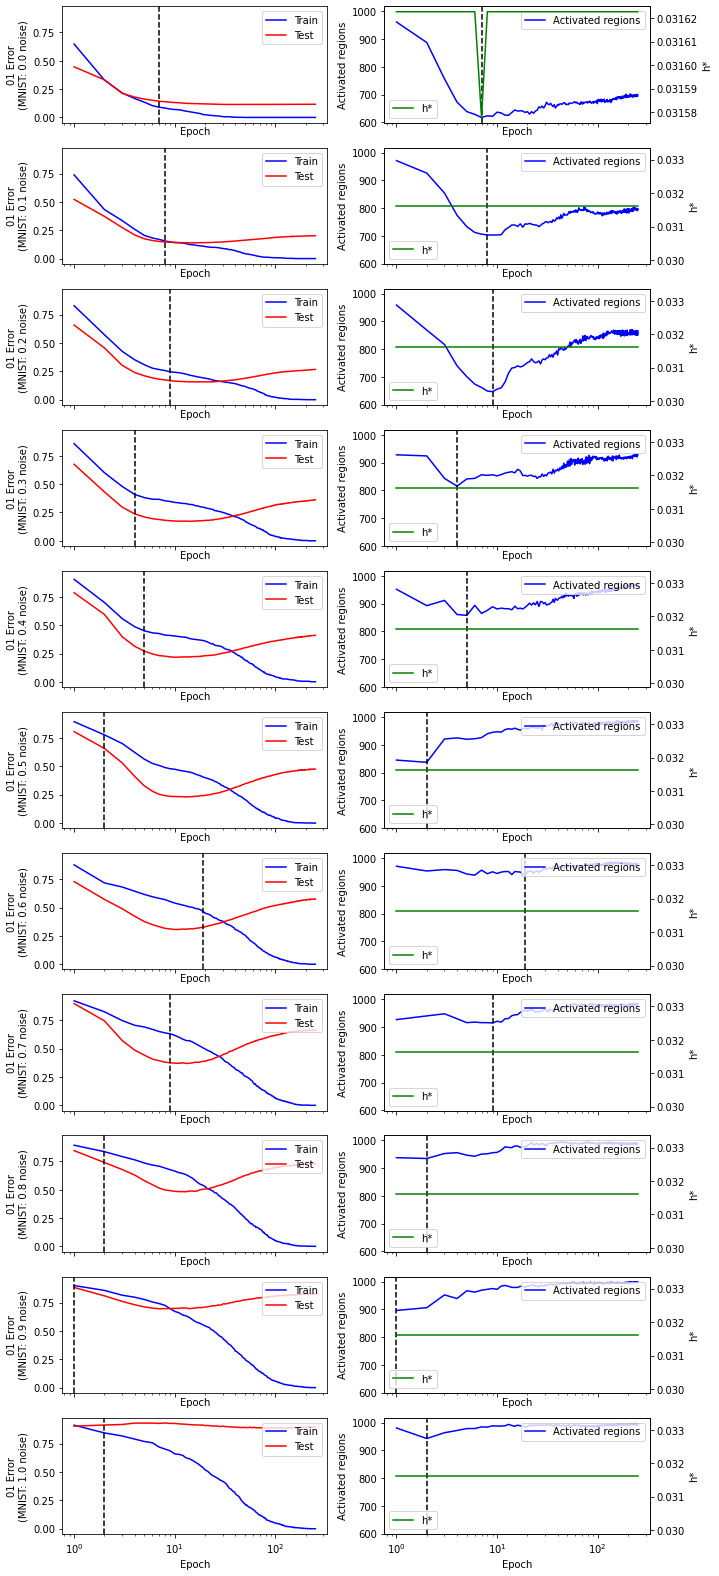

In [90]:
h_key = 'h*'# 'h_argmin'

n_rows = len(results_dict.keys())
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 2*n_rows), sharex=True, sharey='col')

for idx, (shuffle_frac, sub_dict) in enumerate(results_dict.items()):
    train_error = 1 - np.asarray(sub_dict['train_accuracy'])
    test_error = 1 - np.asarray(sub_dict['test_accuracy'])
    train_loss = np.asarray(sub_dict['train_loss'])
    n_regions = sub_dict['n_activated_regions']
    eces = sub_dict['test_ece']

    epochs = np.arange(len(train_error)) + 1

    h_stars = sub_dict[h_key]

    ax1, ax2 = axes[idx]
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # ax.plot(epochs, train_loss, c='blue', label='Train')
    ax1.plot(epochs, train_error, c='blue', label='Train')
    ax1.plot(epochs, test_error, c='red', label='Test')
    ax1.legend(loc='upper right')
    ax1.set_xscale('log')
    ax1.set_ylabel(f'01 Error\n(MNIST: {shuffle_frac:.1f} noise)')
    ax1.set_xlabel('Epoch')
    
#     error_switch_epoch = epochs[np.argmax(train_error <= test_error)]
#     ax1.axvline(error_switch_epoch, ls='--', c='black')
    min_regions = epochs[np.argmin(n_regions)]
    ax1.axvline(min_regions, ls='--', c='black')

#     ax1_twin = ax1.twinx()
#     ax1_twin.plot(epochs, eces, c='purple', label='ECE')
#     ax1_twin.legend(loc='lower left')
#     ax1_twin.set_ylabel('ECE')
    
    ax2.plot(epochs, n_regions, c='blue', label='Activated regions')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epoch')
    ax2.set_xscale('log')
    ax2.set_ylabel('Activated regions')
    
    # ax2.axvline(error_switch_epoch, ls='--', c='black')
    ax2.axvline(min_regions, ls='--', c='black')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, h_stars, c='green', label=h_key)
    ax2_twin.legend(loc='lower left')
    ax2_twin.set_ylabel(h_key)

#     plt.suptitle(
#         f'MNIST (n_train={n_train_sample}), Shuffled label fraction={shuffle_frac:.1f}\n' +
#         f'ReLu Network (layer units={n_units})')
plt.tight_layout()
plt.show()

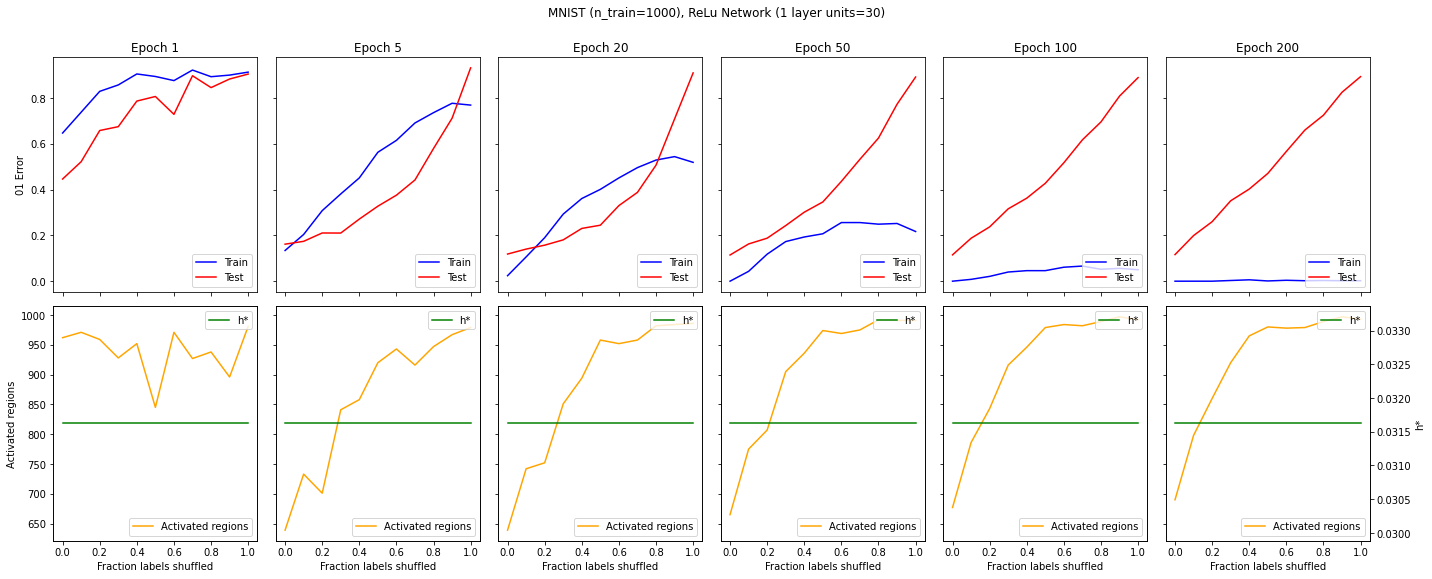

In [107]:
h_key = 'h*' # 'h_argmin'

exogenous_vars = list(results_dict.keys())
train_error = 1 - np.asarray([results_dict[k]['train_accuracy'] for k in exogenous_vars])
test_error = 1 - np.asarray([results_dict[k]['test_accuracy'] for k in exogenous_vars])
h_stars = np.asarray([results_dict[k][h_key] for k in exogenous_vars])
regions = np.asarray([results_dict[k]['n_activated_regions'] for k in exogenous_vars])
eces = np.asarray([results_dict[k]['test_ece'] for k in exogenous_vars])

fig, (ax1, ax2) = plt.subplots(2, 6, figsize=(20, 8), sharex=True, sharey='row')

epochs = np.asarray([1, 5, 20, 50, 100, 200]) - 1

for i, ax in enumerate(ax1):
    ax.plot(exogenous_vars, train_error[:, epochs[i]], c='blue', label='Train')
    ax.plot(exogenous_vars, test_error[:, epochs[i]], c='red', label='Test')
    ax.legend(loc='lower right')
    # ax.set_xscale('log')
#     ax_twin = ax.twinx()
#     ax_twin.plot(exogenous_vars, eces[:, epochs[i]], c='purple', label='ECE')
#     ax_twin.legend(loc='upper right')
    if i < len(ax1) - 1:
        ax_twin.set_yticks([])
    ax.set_title(f'Epoch {epochs[i]+1}')
ax1[0].set_ylabel('01 Error')
ax_twin.set_ylabel('ECE (Expected calibration error)')

for i, ax in enumerate(ax2):
    ax.plot(exogenous_vars, regions[:, epochs[i]], c='orange', label='Activated regions')
    ax.legend(loc='lower right')
    # ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(exogenous_vars, h_stars[:, epochs[i]], c='green', label=h_key)
    ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
    ax.set_xlabel('Fraction labels shuffled')
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel(h_key)

plt.suptitle(
    f'MNIST (n_train={n_train_sample}), ReLu Network (1 layer units={n_units})', y=1)
plt.tight_layout()
plt.show()

## More units

In [5]:
n_units = 100
n_train_sample = 1000
n_epochs = 100
shuffle_fracs = np.linspace(0, 1, 11)

model_base = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),#input_shape=(28, 28)),
    tf.keras.layers.Dense(n_units, activation='relu'),
    tf.keras.layers.Dense(10)
])

results_dict = {}
for shuffle_frac in tqdm(shuffle_fracs):
    total_params = (28 * 28 + 1) * n_units + (n_units + 1) * 10
    
    model = tf.keras.models.clone_model(model_base)
    
    optimizer = tf.keras.optimizers.Adam(0.001)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metric = tf.keras.metrics.SparseCategoricalAccuracy()
    
    ds_train, ds_test = prepare_mnist_dataset(
        train_sample_size=n_train_sample, test_sample_size=10000,
        shuffle_label_frac=shuffle_frac, seed=0)
    
    model, model_results = fit_model(model, n_epochs, optimizer, loss_fn, metric)
    
    results_dict[shuffle_frac] = model_results

  0%|          | 0/11 [00:00<?, ?it/s]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.465, Validation acc=0.699
Epoch 5: Training acc=0.925, Validation acc=0.875
Epoch 10: Training acc=0.976, Validation acc=0.887
Epoch 15: Training acc=0.993, Validation acc=0.892
Epoch 20: Training acc=0.999, Validation acc=0.892
Epoch 25: Training acc=1.000, Validation acc=0.892
Epoch 30: Training acc=1.000, Validation acc=0.893
Epoch 35: Training acc=1.000, Validation acc=0.893
Epoch 40: Training acc=1.000, Validation acc=0.893
Epoch 45: Training acc=1.000, Validation acc=0.893
Epoch 50: Training acc=1.000, Validation acc=0.893
Epoch 55: Training acc=1.000, Validation acc=0.894
Epoch 60: Training acc=1.000, Validation acc=0.894
Epoch 65: Training acc=1.000, Validation acc=0.894
Epoch 70: Training acc=1.000, Validation acc=0.894
Epoch 75: Training acc=1.000, Validation acc=0.894
Epoch 80: Training acc=1.000, Validation acc=0.895
Epoch 85: Training acc=1.000, Validation acc=

  9%|▉         | 1/11 [00:46<07:48, 46.80s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.392, Validation acc=0.654
Epoch 5: Training acc=0.857, Validation acc=0.858
Epoch 10: Training acc=0.892, Validation acc=0.862
Epoch 15: Training acc=0.917, Validation acc=0.862
Epoch 20: Training acc=0.933, Validation acc=0.856
Epoch 25: Training acc=0.957, Validation acc=0.852
Epoch 30: Training acc=0.971, Validation acc=0.848
Epoch 35: Training acc=0.981, Validation acc=0.845
Epoch 40: Training acc=0.986, Validation acc=0.844
Epoch 45: Training acc=0.990, Validation acc=0.842
Epoch 50: Training acc=0.992, Validation acc=0.841
Epoch 55: Training acc=0.993, Validation acc=0.839
Epoch 60: Training acc=0.994, Validation acc=0.840
Epoch 65: Training acc=0.995, Validation acc=0.838
Epoch 70: Training acc=0.997, Validation acc=0.838
Epoch 75: Training acc=0.998, Validation acc=0.837
Epoch 80: Training acc=0.999, Validation acc=0.836
Epoch 85: Training acc=1.000, Validation acc=

 18%|█▊        | 2/11 [01:33<07:01, 46.79s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.281, Validation acc=0.590
Epoch 5: Training acc=0.766, Validation acc=0.846
Epoch 10: Training acc=0.818, Validation acc=0.853
Epoch 15: Training acc=0.841, Validation acc=0.846
Epoch 20: Training acc=0.867, Validation acc=0.839
Epoch 25: Training acc=0.893, Validation acc=0.831
Epoch 30: Training acc=0.921, Validation acc=0.823
Epoch 35: Training acc=0.950, Validation acc=0.816
Epoch 40: Training acc=0.964, Validation acc=0.810
Epoch 45: Training acc=0.971, Validation acc=0.804
Epoch 50: Training acc=0.975, Validation acc=0.801
Epoch 55: Training acc=0.979, Validation acc=0.797
Epoch 60: Training acc=0.984, Validation acc=0.795
Epoch 65: Training acc=0.987, Validation acc=0.794
Epoch 70: Training acc=0.990, Validation acc=0.791
Epoch 75: Training acc=0.991, Validation acc=0.791
Epoch 80: Training acc=0.993, Validation acc=0.790
Epoch 85: Training acc=0.996, Validation acc=

 27%|██▋       | 3/11 [02:19<06:12, 46.52s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.214, Validation acc=0.514
Epoch 5: Training acc=0.657, Validation acc=0.840
Epoch 10: Training acc=0.718, Validation acc=0.841
Epoch 15: Training acc=0.765, Validation acc=0.825
Epoch 20: Training acc=0.814, Validation acc=0.806
Epoch 25: Training acc=0.856, Validation acc=0.790
Epoch 30: Training acc=0.899, Validation acc=0.774
Epoch 35: Training acc=0.935, Validation acc=0.764
Epoch 40: Training acc=0.951, Validation acc=0.756
Epoch 45: Training acc=0.968, Validation acc=0.747
Epoch 50: Training acc=0.975, Validation acc=0.742
Epoch 55: Training acc=0.979, Validation acc=0.738
Epoch 60: Training acc=0.984, Validation acc=0.734
Epoch 65: Training acc=0.987, Validation acc=0.730
Epoch 70: Training acc=0.988, Validation acc=0.729
Epoch 75: Training acc=0.989, Validation acc=0.726
Epoch 80: Training acc=0.993, Validation acc=0.724
Epoch 85: Training acc=0.994, Validation acc=

 36%|███▋      | 4/11 [03:06<05:25, 46.50s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.197, Validation acc=0.495
Epoch 5: Training acc=0.601, Validation acc=0.806
Epoch 10: Training acc=0.655, Validation acc=0.791
Epoch 15: Training acc=0.706, Validation acc=0.768
Epoch 20: Training acc=0.763, Validation acc=0.743
Epoch 25: Training acc=0.828, Validation acc=0.725
Epoch 30: Training acc=0.873, Validation acc=0.707
Epoch 35: Training acc=0.909, Validation acc=0.695
Epoch 40: Training acc=0.935, Validation acc=0.684
Epoch 45: Training acc=0.949, Validation acc=0.676
Epoch 50: Training acc=0.962, Validation acc=0.669
Epoch 55: Training acc=0.966, Validation acc=0.662
Epoch 60: Training acc=0.974, Validation acc=0.658
Epoch 65: Training acc=0.980, Validation acc=0.654
Epoch 70: Training acc=0.983, Validation acc=0.650
Epoch 75: Training acc=0.987, Validation acc=0.647
Epoch 80: Training acc=0.991, Validation acc=0.642
Epoch 85: Training acc=0.992, Validation acc=

 45%|████▌     | 5/11 [03:52<04:38, 46.43s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.146, Validation acc=0.388
Epoch 5: Training acc=0.543, Validation acc=0.781
Epoch 10: Training acc=0.602, Validation acc=0.762
Epoch 15: Training acc=0.670, Validation acc=0.734
Epoch 20: Training acc=0.743, Validation acc=0.705
Epoch 25: Training acc=0.823, Validation acc=0.682
Epoch 30: Training acc=0.875, Validation acc=0.658
Epoch 35: Training acc=0.915, Validation acc=0.639
Epoch 40: Training acc=0.942, Validation acc=0.627
Epoch 45: Training acc=0.955, Validation acc=0.616
Epoch 50: Training acc=0.970, Validation acc=0.607
Epoch 55: Training acc=0.981, Validation acc=0.601
Epoch 60: Training acc=0.984, Validation acc=0.596
Epoch 65: Training acc=0.987, Validation acc=0.593
Epoch 70: Training acc=0.990, Validation acc=0.588
Epoch 75: Training acc=0.992, Validation acc=0.584
Epoch 80: Training acc=0.993, Validation acc=0.581
Epoch 85: Training acc=0.996, Validation acc=

 55%|█████▍    | 6/11 [04:38<03:50, 46.19s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.109, Validation acc=0.281
Epoch 5: Training acc=0.459, Validation acc=0.701
Epoch 10: Training acc=0.547, Validation acc=0.683
Epoch 15: Training acc=0.631, Validation acc=0.640
Epoch 20: Training acc=0.711, Validation acc=0.612
Epoch 25: Training acc=0.785, Validation acc=0.583
Epoch 30: Training acc=0.852, Validation acc=0.562
Epoch 35: Training acc=0.891, Validation acc=0.546
Epoch 40: Training acc=0.924, Validation acc=0.531
Epoch 45: Training acc=0.944, Validation acc=0.520
Epoch 50: Training acc=0.965, Validation acc=0.511
Epoch 55: Training acc=0.971, Validation acc=0.506
Epoch 60: Training acc=0.978, Validation acc=0.500
Epoch 65: Training acc=0.983, Validation acc=0.495
Epoch 70: Training acc=0.989, Validation acc=0.491
Epoch 75: Training acc=0.990, Validation acc=0.486
Epoch 80: Training acc=0.991, Validation acc=0.484
Epoch 85: Training acc=0.993, Validation acc=

 64%|██████▎   | 7/11 [05:24<03:04, 46.12s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.096, Validation acc=0.258
Epoch 5: Training acc=0.413, Validation acc=0.654
Epoch 10: Training acc=0.521, Validation acc=0.620
Epoch 15: Training acc=0.626, Validation acc=0.567
Epoch 20: Training acc=0.722, Validation acc=0.523
Epoch 25: Training acc=0.805, Validation acc=0.493
Epoch 30: Training acc=0.862, Validation acc=0.468
Epoch 35: Training acc=0.901, Validation acc=0.454
Epoch 40: Training acc=0.927, Validation acc=0.441
Epoch 45: Training acc=0.947, Validation acc=0.430
Epoch 50: Training acc=0.964, Validation acc=0.423
Epoch 55: Training acc=0.973, Validation acc=0.417
Epoch 60: Training acc=0.984, Validation acc=0.410
Epoch 65: Training acc=0.991, Validation acc=0.401
Epoch 70: Training acc=0.993, Validation acc=0.398
Epoch 75: Training acc=0.994, Validation acc=0.395
Epoch 80: Training acc=0.997, Validation acc=0.391
Epoch 85: Training acc=0.998, Validation acc=

 73%|███████▎  | 8/11 [06:10<02:18, 46.13s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.123, Validation acc=0.208
Epoch 5: Training acc=0.372, Validation acc=0.553
Epoch 10: Training acc=0.511, Validation acc=0.503
Epoch 15: Training acc=0.605, Validation acc=0.456
Epoch 20: Training acc=0.708, Validation acc=0.422
Epoch 25: Training acc=0.793, Validation acc=0.389
Epoch 30: Training acc=0.859, Validation acc=0.370
Epoch 35: Training acc=0.901, Validation acc=0.354
Epoch 40: Training acc=0.933, Validation acc=0.341
Epoch 45: Training acc=0.959, Validation acc=0.329
Epoch 50: Training acc=0.976, Validation acc=0.324
Epoch 55: Training acc=0.981, Validation acc=0.318
Epoch 60: Training acc=0.985, Validation acc=0.314
Epoch 65: Training acc=0.992, Validation acc=0.310
Epoch 70: Training acc=0.993, Validation acc=0.308
Epoch 75: Training acc=0.993, Validation acc=0.306
Epoch 80: Training acc=0.996, Validation acc=0.306
Epoch 85: Training acc=0.998, Validation acc=

 82%|████████▏ | 9/11 [06:55<01:31, 45.91s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.108, Validation acc=0.157
Epoch 5: Training acc=0.354, Validation acc=0.325
Epoch 10: Training acc=0.473, Validation acc=0.287
Epoch 15: Training acc=0.603, Validation acc=0.264
Epoch 20: Training acc=0.716, Validation acc=0.241
Epoch 25: Training acc=0.814, Validation acc=0.225
Epoch 30: Training acc=0.860, Validation acc=0.213
Epoch 35: Training acc=0.912, Validation acc=0.205
Epoch 40: Training acc=0.932, Validation acc=0.203
Epoch 45: Training acc=0.959, Validation acc=0.200
Epoch 50: Training acc=0.974, Validation acc=0.199
Epoch 55: Training acc=0.978, Validation acc=0.197
Epoch 60: Training acc=0.983, Validation acc=0.194
Epoch 65: Training acc=0.987, Validation acc=0.192
Epoch 70: Training acc=0.994, Validation acc=0.193
Epoch 75: Training acc=0.996, Validation acc=0.193
Epoch 80: Training acc=0.997, Validation acc=0.190
Epoch 85: Training acc=0.997, Validation acc=

 91%|█████████ | 10/11 [07:41<00:45, 45.75s/it]

x_train.shape=(1000, 28, 28) y_train=(1000,) x_test.shape=(10000, 28, 28) y_test=(10000,)
Epoch 0: Training acc=0.097, Validation acc=0.085
Epoch 5: Training acc=0.389, Validation acc=0.098
Epoch 10: Training acc=0.520, Validation acc=0.106
Epoch 15: Training acc=0.650, Validation acc=0.112
Epoch 20: Training acc=0.757, Validation acc=0.119
Epoch 25: Training acc=0.845, Validation acc=0.120
Epoch 30: Training acc=0.896, Validation acc=0.121
Epoch 35: Training acc=0.930, Validation acc=0.118
Epoch 40: Training acc=0.955, Validation acc=0.119
Epoch 45: Training acc=0.969, Validation acc=0.120
Epoch 50: Training acc=0.979, Validation acc=0.117
Epoch 55: Training acc=0.986, Validation acc=0.116
Epoch 60: Training acc=0.989, Validation acc=0.116
Epoch 65: Training acc=0.994, Validation acc=0.116
Epoch 70: Training acc=0.996, Validation acc=0.115
Epoch 75: Training acc=0.996, Validation acc=0.116
Epoch 80: Training acc=0.999, Validation acc=0.115
Epoch 85: Training acc=0.999, Validation acc=

100%|██████████| 11/11 [08:26<00:00, 46.07s/it]


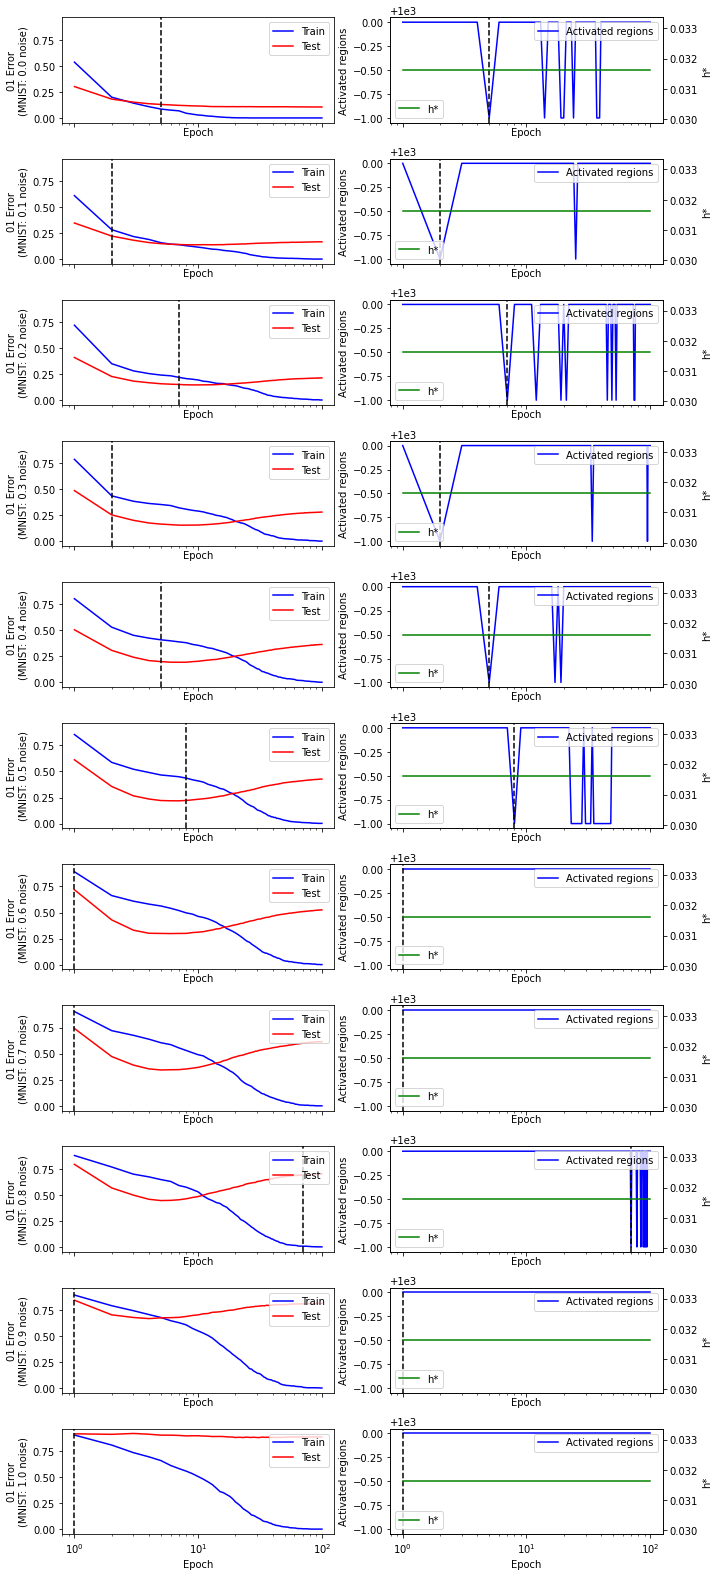

In [6]:
h_key = 'h*'# 'h_argmin'

n_rows = len(results_dict.keys())
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 2*n_rows), sharex=True, sharey='col')

for idx, (shuffle_frac, sub_dict) in enumerate(results_dict.items()):
    train_error = 1 - np.asarray(sub_dict['train_accuracy'])
    test_error = 1 - np.asarray(sub_dict['test_accuracy'])
    train_loss = np.asarray(sub_dict['train_loss'])
    n_regions = sub_dict['n_activated_regions']
    eces = sub_dict['test_ece']

    epochs = np.arange(len(train_error)) + 1

    h_stars = sub_dict[h_key]

    ax1, ax2 = axes[idx]
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    # ax.plot(epochs, train_loss, c='blue', label='Train')
    ax1.plot(epochs, train_error, c='blue', label='Train')
    ax1.plot(epochs, test_error, c='red', label='Test')
    ax1.legend(loc='upper right')
    ax1.set_xscale('log')
    ax1.set_ylabel(f'01 Error\n(MNIST: {shuffle_frac:.1f} noise)')
    ax1.set_xlabel('Epoch')
    
#     error_switch_epoch = epochs[np.argmax(train_error <= test_error)]
#     ax1.axvline(error_switch_epoch, ls='--', c='black')
    min_regions = epochs[np.argmin(n_regions)]
    ax1.axvline(min_regions, ls='--', c='black')

#     ax1_twin = ax1.twinx()
#     ax1_twin.plot(epochs, eces, c='purple', label='ECE')
#     ax1_twin.legend(loc='lower left')
#     ax1_twin.set_ylabel('ECE')
    
    ax2.plot(epochs, n_regions, c='blue', label='Activated regions')
    ax2.legend(loc='upper right')
    ax2.set_xlabel('Epoch')
    ax2.set_xscale('log')
    ax2.set_ylabel('Activated regions')
    
    # ax2.axvline(error_switch_epoch, ls='--', c='black')
    ax2.axvline(min_regions, ls='--', c='black')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(epochs, h_stars, c='green', label=h_key)
    ax2_twin.legend(loc='lower left')
    ax2_twin.set_ylabel(h_key)

#     plt.suptitle(
#         f'MNIST (n_train={n_train_sample}), Shuffled label fraction={shuffle_frac:.1f}\n' +
#         f'ReLu Network (layer units={n_units})')
plt.tight_layout()
plt.show()

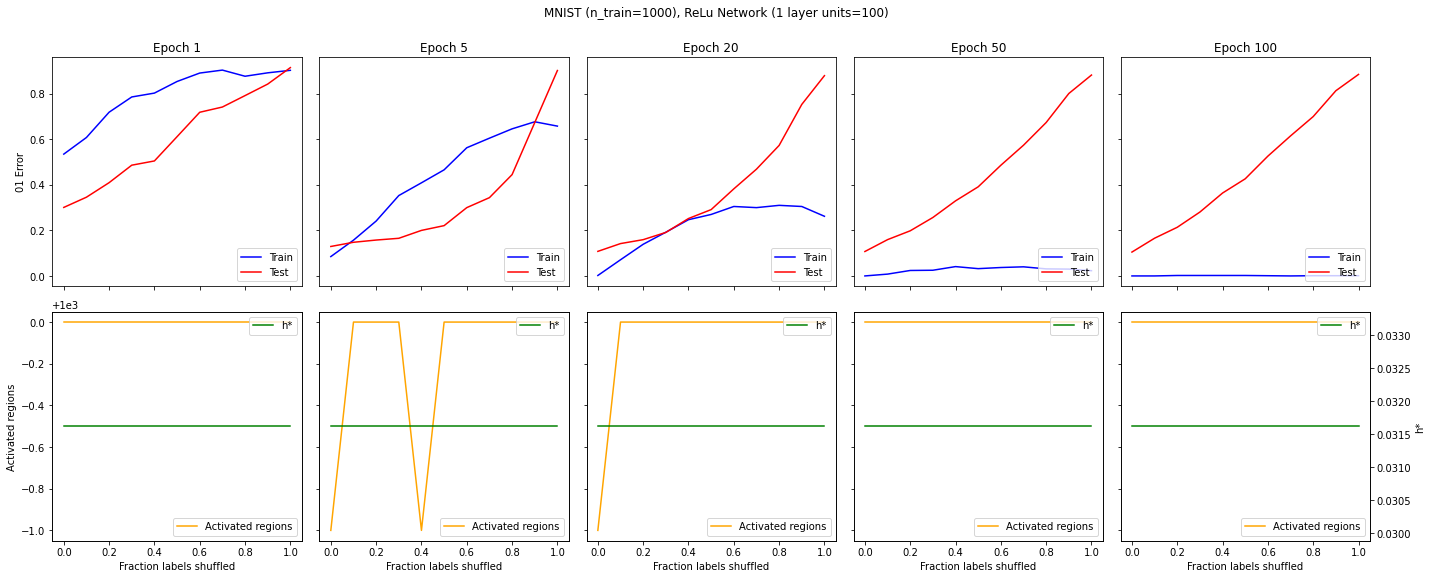

In [9]:
h_key = 'h*' # 'h_argmin'

exogenous_vars = list(results_dict.keys())
train_error = 1 - np.asarray([results_dict[k]['train_accuracy'] for k in exogenous_vars])
test_error = 1 - np.asarray([results_dict[k]['test_accuracy'] for k in exogenous_vars])
h_stars = np.asarray([results_dict[k][h_key] for k in exogenous_vars])
regions = np.asarray([results_dict[k]['n_activated_regions'] for k in exogenous_vars])
eces = np.asarray([results_dict[k]['test_ece'] for k in exogenous_vars])

fig, (ax1, ax2) = plt.subplots(2, 5, figsize=(20, 8), sharex=True, sharey='row')

epochs = np.asarray([1, 5, 20, 50, 100]) - 1

for i, ax in enumerate(ax1):
    ax.plot(exogenous_vars, train_error[:, epochs[i]], c='blue', label='Train')
    ax.plot(exogenous_vars, test_error[:, epochs[i]], c='red', label='Test')
    ax.legend(loc='lower right')
    # ax.set_xscale('log')
#     ax_twin = ax.twinx()
#     ax_twin.plot(exogenous_vars, eces[:, epochs[i]], c='purple', label='ECE')
#     ax_twin.legend(loc='upper right')
#     if i < len(ax1) - 1:
#         ax_twin.set_yticks([])
    ax.set_title(f'Epoch {epochs[i]+1}')
ax1[0].set_ylabel('01 Error')
# ax_twin.set_ylabel('ECE (Expected calibration error)')

for i, ax in enumerate(ax2):
    ax.plot(exogenous_vars, regions[:, epochs[i]], c='orange', label='Activated regions')
    ax.legend(loc='lower right')
    # ax.set_xscale('log')
    ax_twin = ax.twinx()
    ax_twin.plot(exogenous_vars, h_stars[:, epochs[i]], c='green', label=h_key)
    ax_twin.legend(loc='upper right')
    if i < len(ax2) - 1:
        ax_twin.set_yticks([])
    ax.set_xlabel('Fraction labels shuffled')
ax2[0].set_ylabel('Activated regions')
ax_twin.set_ylabel(h_key)

plt.suptitle(
    f'MNIST (n_train={n_train_sample}), ReLu Network (1 layer units={n_units})', y=1)
plt.tight_layout()
plt.show()